In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

In [64]:
# Convertir le dictionnaire en DataFrame

df = pd.read_csv('dataset1.csv', sep=';')
df = df.dropna()

# Remplacer les valeurs dans grading par des int
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Remplace date par un dictionnaire {months: number, years: number}
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return {'months': 0, 'years': 0}
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return {'months': int(date_array[0]), 'years': 0}
        return {'months': 1, 'years': 0}
    elif date_array[0].isdigit():
        return {'months': int(date_array[0])*12, 'years': int(date_array[0])}
    return {'months': 12, 'years': 1}

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame

# Pour que les détections soient consistent
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

,Name,grading,date,Text,Target,Language
ID,,,,,,
1,Wissem Smaali,1,"{'months': 11, 'years': 0}","À éviter\nLe Pirée boulangerie de Vitry , le v...",0,fr
2,ted tenore,1,"{'months': 4, 'years': 0}",Je précise l’étoile je le donne que pour les c...,0,fr
3,Sly yo!,1,"{'months': 4, 'years': 0}",Dommage pour le pâtissier qui ce démène et mes...,0,fr
4,Emiie.R D,1,"{'months': 1, 'years': 0}",Dommage les produits sont très bon mais les ve...,0,fr
5,Michael,1,"{'months': 1, 'years': 0}","Si je pouvais mettre -1000 je l’aurais fait, j...",0,fr
...,...,...,...,...,...,...
3599,sonia bobrie,5,"{'months': 3, 'years': 0}",Service de qualité au rayon dressing/rangement...,2,fr
4482,Aleksander Callaud,5,"{'months': 24, 'years': 2}","Très bon restaurant, avec un personnel très sy...",2,fr
4483,La fée toute seule,5,"{'months': 10, 'years': 0}",Une valeur sûre à Beauvais. Bon accueil et tar...,2,fr


## Translation

In [65]:
"""#pip install google-cloud-translate==2.0.1
from google.cloud import translate_v2 as translate
import os, json
from dotenv import load_dotenv
load_dotenv()

CREDENTIALS = json.loads(os.environ.get('CREDENTIALS'))

if os.path.exists('credentials.json'):
    pass
else:
    with open('credentials.json', 'w') as credFile:
        json.dump(CREDENTIALS, credFile)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'

def translate_text(row):
    translate_client = translate.Client()

    text = row['Text']
    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Only translate the text if the language isn't 'en'.
    if row['Language'] != 'en':
        try:
            result = translate_client.translate(text, target_language='en')
            return pd.Series([result["translatedText"], 'en'])
        except Exception:
            return pd.Series([text, row['Language']])  # if translation fails, return original text and language
    else:
        return pd.Series([text, row['Language']])  # if text is already in English, return original text and language

df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df
"""

from deep_translator import GoogleTranslator

def translate_text(df):
    for i, row in df.iterrows():
        if row['Language'] != 'en':
            text = row['Text']
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            df.at[i, 'Text'] = translated_text
            df.at[i, 'Language'] = 'en'
    return df

# Apply the function to the DataFrame
df = translate_text(df)
df

,Name,grading,date,Text,Target,Language
ID,,,,,,
1,Wissem Smaali,1,"{'months': 11, 'years': 0}","To avoid\nThe Piraeus bakery in Vitry, the sal...",0,en
2,ted tenore,1,"{'months': 4, 'years': 0}",I specify the star I give it only for the croi...,0,en
3,Sly yo!,1,"{'months': 4, 'years': 0}",Too bad for the pastry chef who struggles and ...,0,en
4,Emiie.R D,1,"{'months': 1, 'years': 0}",Too bad the products are very good but the sal...,0,en
5,Michael,1,"{'months': 1, 'years': 0}","If I could put -1000 I would have, I asked for...",0,en
...,...,...,...,...,...,...
3599,sonia bobrie,5,"{'months': 3, 'years': 0}",Quality service in the dressing room/storage d...,2,en
4482,Aleksander Callaud,5,"{'months': 24, 'years': 2}","Very good restaurant, with very friendly staff...",2,en
4483,La fée toute seule,5,"{'months': 10, 'years': 0}",A safe bet in Beauvais. Good reception and fai...,2,en


## EDA

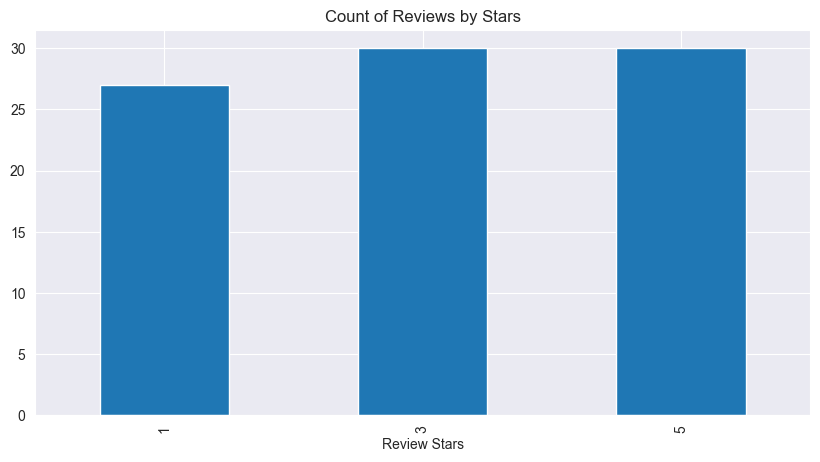

In [66]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [67]:
from transformers import pipeline
from transformers import AutoTokenizer

In [68]:
# Sentiment Analysis with Roberta
"""
nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)
"""
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,Name,grading,date,Text,Target,Language,label (roberta),score (roberta)
ID,,,,,,,,
1,Wissem Smaali,1,"{'months': 11, 'years': 0}","To avoid\nThe Piraeus bakery in Vitry, the sal...",0,en,NEGATIVE,0.889870
2,ted tenore,1,"{'months': 4, 'years': 0}",I specify the star I give it only for the croi...,0,en,NEGATIVE,0.558830
3,Sly yo!,1,"{'months': 4, 'years': 0}",Too bad for the pastry chef who struggles and ...,0,en,NEGATIVE,0.916203
4,Emiie.R D,1,"{'months': 1, 'years': 0}",Too bad the products are very good but the sal...,0,en,NEGATIVE,0.777332
5,Michael,1,"{'months': 1, 'years': 0}","If I could put -1000 I would have, I asked for...",0,en,NEUTRAL,0.500744
...,...,...,...,...,...,...,...,...
3599,sonia bobrie,5,"{'months': 3, 'years': 0}",Quality service in the dressing room/storage d...,2,en,POSITIVE,0.989260
4482,Aleksander Callaud,5,"{'months': 24, 'years': 2}","Very good restaurant, with very friendly staff...",2,en,POSITIVE,0.987408
4483,La fée toute seule,5,"{'months': 10, 'years': 0}",A safe bet in Beauvais. Good reception and fai...,2,en,POSITIVE,0.952969


## nlptown/bert-base-multilingual-uncased-sentiment

In [69]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu
"""
nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':

        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={'label': 'label (Bert), over 5', 'score': 'score (Bert)'})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df
"""
# print(df.isnull().sum())
# print(f"Negative: {df[df['label (roberta)'] == 'NEGATIVE'].count()}, Positive: {df[df['label (roberta)'] == 'POSITIVE'].count()}, Neutral: {df[df['label (roberta)'] == 'NEUTRAL'].count()}")


'\nnlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\' or langue == \'fr\' or langue == \'es\' or langue == \'it\' or langue == \'de\' or langue == \'nl\':\n\n        tokens = tokenizer.encode(text, return_tensors=\'pt\')\n\n        if len(tokens[0]) <= 512:\n            dict = pd.DataFrame(nlp(text))\n            dict[\'ID\'] = index\n            res = pd.concat([res, dict], axis=0)\n\n# Remplacement des valeurs\nres[\'label\'] = res[\'label\'].replace(\'1 star\', int(1))\nres[\'label\'] = res[\'label\'].replace(\'2 stars\', int(2))\nres[\'label\'] = res[\'label\'].replace(\'3 stars\', int(3))\nres[\'label\'] = res[\'label\'].replace(\'4 stars\', int(4))\nres[\'label\'] = res[\'label\'].replace(\'5 stars\', int(5))\nres["ID"] 

## Using Sklearn

In [70]:
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df.drop(df[df['label (roberta)'].isna()].index)

# Assume X is your list of texts and y is your list of labels
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)

# Transform the text data into numerical vectors
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Test the classifier
predictions = clf.predict(X_test_vectors)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# DISPLAY CONFUSION MATRIX
# Transpose the confusion matrix
cm = cm.T
# Define the labels of the matrix
labels = ['Negative', 'Neutral', 'Positive']
# Create a dataframe from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Display the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()
"""

"\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\ndf = df.drop(df[df['label (roberta)'].isna()].index)\n\n# Assume X is your list of texts and y is your list of labels\nX_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)\n\n# Transform the text data into numerical vectors\nvectorizer = CountVectorizer()\nX_train_vectors = vectorizer.fit_transform(X_train)\nX_test_vectors = vectorizer.transform(X_test)\n\n# Train the classifier\nclf = MultinomialNB()\nclf.fit(X_train_vectors, y_train)\n\n# Test the classifier\npredictions = clf.predict(X_test_vectors)\n\n# Calculate metrics\naccuracy = accuracy_score(y_test, predictions)\nprecision = precision_score(y_test, predictions, average='weighted', zero_division=0)\nrecall = recall_score(y_test, pr

## Exportation des données

In [71]:
import csv

chemin_fichier = 'processed_data.csv'

# Exporter le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier, index=False)

## Score du modèle

In [72]:
test_df = pd.read_csv('dataset1.csv', sep=';')
print(test_df.shape)
test_df.head()

(5015, 5)


,Name,grading,date,Text,Target
0,Alvin Alias,1 star,7 months ago,Over priced and unfriendly staff,NaN
1,Wissem Smaali,1 star,11 months ago,"À éviter\nLe Pirée boulangerie de Vitry , le v...",0
2,ted tenore,1 star,4 months ago,Je précise l’étoile je le donne que pour les c...,0
3,Sly yo!,1 star,4 months ago,Dommage pour le pâtissier qui ce démène et mes...,0
4,Emiie.R D,1 star,a month ago,Dommage les produits sont très bon mais les ve...,0


In [73]:
test_df = test_df.dropna()
test_df.shape

(87, 5)

In [74]:
X_test = test_df['Text']
y_test = test_df['Target']
X_test

1       À éviter\nLe Pirée boulangerie de Vitry , le v...
2       Je précise l’étoile je le donne que pour les c...
3       Dommage pour le pâtissier qui ce démène et mes...
4       Dommage les produits sont très bon mais les ve...
5       Si je pouvais mettre -1000 je l’aurais fait, j...
                              ...                        
3599    Service de qualité au rayon dressing/rangement...
4482    Très bon restaurant, avec un personnel très sy...
4483    Une valeur sûre à Beauvais. Bon accueil et tar...
4484    Très bon burger, et très bonne bière en pressi...
4487    Restaurant sympa et très bon service. Je recom...
Name: Text, Length: 87, dtype: object

In [75]:
# Traduire les phrases en anglais

X_test = X_test.apply(GoogleTranslator(source='auto', target='en').translate)
X_test

1       To avoid\nThe Piraeus bakery in Vitry, the sal...
2       I specify the star I give it only for the croi...
3       Too bad for the pastry chef who struggles and ...
4       Too bad the products are very good but the sal...
5       If I could put -1000 I would have, I asked for...
                              ...                        
3599    Quality service in the dressing room/storage d...
4482    Very good restaurant, with very friendly staff...
4483    A safe bet in Beauvais. Good reception and fai...
4484    Very good burger, and very good draft beer. Go...
4487    Nice restaurant and very good service. I recom...
Name: Text, Length: 87, dtype: object

In [76]:
y_pred = X_test.apply(lambda x: nlp(x)[0]['label'])

In [77]:
# remplacer LABEL_0 par 0, LABEL_1 par 1 et LABEL_2 par 2
y_pred = y_pred.replace('LABEL_0', 0)
y_pred = y_pred.replace('LABEL_1', 1)
y_pred = y_pred.replace('LABEL_2', 2)
y_pred

1       0
2       0
3       0
4       0
5       1
       ..
3599    2
4482    2
4483    2
4484    2
4487    2
Name: Text, Length: 87, dtype: int64

1       0
2       0
3       0
4       0
5       1
       ..
3599    2
4482    2
4483    2
4484    2
4487    2
Name: Text, Length: 87, dtype: int64

In [78]:
def accuracy(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [79]:
# Remplacer la valeur de la ligne 1515 par 0
y_test = y_test.replace('À', 0)

In [80]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [81]:
score = accuracy(y_test, y_pred)
print(f"Accuracy: {score:.2f}")

Accuracy: 0.70
Accuracy: 0.70
